In [ ]:
Построим вспомогательный класс для работы с регрессиями.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.style as style
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm
%config InlineBackend.figure_format = 'svg'
np.set_printoptions(suppress=True)


class Model:
    def __init__(self,dataframe,y_name,X_names):
        self.y_name = y_name
        self.X_names = X_names
        self.no_ones_X = np.array(dataframe[X_names])
        self.k = self.no_ones_X.shape[1] + 1
        self.n = self.no_ones_X.shape[0]
        self.y = np.array(dataframe[y_name]).reshape(self.n,-1)
        self.X = np.hstack((np.ones(self.n).reshape(self.n,-1),self.no_ones_X))
        self.b =  np.dot(np.linalg.inv(np.dot(self.X.T, self.X)),np.dot(self.X.T,self.y))
        self.y_estimated = np.dot(self.X,self.b)
        self.residuals = self.y - self.y_estimated
        self.TSS = sum((self.y-np.mean(self.y)) **2 )
        self.RSS = sum((self.y-self.y_estimated) **2 )
        self.ESS = self.TSS - self.RSS
        self.R2 = self.ESS / self.TSS
        self.sigma = self.RSS / (self.n - self.k)
        self.R2_adjusted = 1 - self.sigma/(self.TSS/(self.n-1))
        self.AIC = self.n * np.log(self.RSS / self.n) + 2 * self.k
        self.BIC = self.n * np.log(self.RSS / self.n) + np.log(self.n) * self.k
        self.b_correlation = self.sigma * np.linalg.inv(np.dot(self.X.T, self.X))
        self.b_std = np.array([[va ** (1/2) for j,va in enumerate(val) if j==i] for i,val in enumerate(self.b_correlation)])
        self.X_mean = self.no_ones_X.mean(axis=0)
        self.X_var = self.no_ones_X.var(axis=0,ddof=1)
        self.X_std = self.no_ones_X.std(axis=0,ddof=1)
        self.X_centred = self.no_ones_X - self.X_mean
        self.X_centr_stand = self.X_centred / self.X_std
        self.X_correlation = np.dot(self.X_centr_stand.T,self.X_centr_stand) / (self.n-1)
    def draw_X_correlation(self):
        def highlight_corr(val):
            if ((val > -0.999 and val < -0.8) or (val < 0.999 and val > 0.8)):
                color = 'DodgerBlue'
            elif ((val >= -0.8 and val < -0.6) or (val <= 0.8 and val > 0.6)):
                color = 'DeepSkyBlue'
            elif ((val >= -0.6 and val < -0.4) or (val < 0.6 and val > 0.4)):
                color = 'LightSkyBlue'
            else:
                color = ''
            return f'background-color:{color}'
        output_df = pd.DataFrame(self.X_correlation,index=self.X_names,columns=self.X_names)
        display(output_df.style.set_caption('Корреляционная матрица независимых переменных').applymap(highlight_corr))
    def draw_b_correlation(self):
        intercept_names = ['Intercept'] + self.X_names
        output_df = pd.DataFrame(self.b_correlation,index=intercept_names,columns=intercept_names)
        display(output_df.style.set_caption('Корреляционная матрица оценок МНК'))
    def stats(self, norm=False):
        intercept_names = ['Intercept'] + self.X_names
        stat_observable = self.b / self.b_std
        if norm:
            p_value = np.round(2*(1 - scipy.stats.norm.cdf(abs(stat_observable))),5)
        else:
            p_value = np.round(2*(1 - scipy.stats.t.cdf(abs(stat_observable),self.n - self.k)),5)
        output_array = np.vstack((self.b.T, self.b_std.T,p_value.T,stat_observable.T))
        output_df = pd.DataFrame(data=output_array,index=['Оценки МНК','Стандартное отклонение оценок','p-значения','наблюдаемое значение'], columns=intercept_names).astype(object)
        display(output_df)
        quantiles_1 = scipy.stats.norm.ppf(0.995) if norm else scipy.stats.t.ppf(0.995,self.n - self.k)
        quantiles_5 = scipy.stats.norm.ppf(0.975) if norm else scipy.stats.t.ppf(0.975,self.n - self.k)
        print(f'Квантиль  5% уровня значимости: {quantiles_5:.2f} Квантиль 1% уровня значимости: {quantiles_1:.2f}')
    def quality(self):
        f_observed = (self.ESS/(self.k-1)) / (self.RSS/(self.n - self.k))
        f_crit = scipy.stats.f.ppf(0.95, self.k-1, self.n - self.k)
        f_pvalue = 1 - scipy.stats.f.cdf(f_observed, self.k-1, self.n - self.k)
        print(f'Значения F-статистики наблюдаемое: {f_observed[0]:.2f}, критическое: {f_crit:.2f}, p-значение: {f_pvalue[0]:.4f}')
        print(f'Показатели качества модели R^2: {self.R2[0]:.4f} R^2 adjusted: {self.R2_adjusted[0]:.4f}, AIC: {self.AIC[0]:.2f}, BIC: {self.BIC[0]:.2f}') 
    def summary(self,norm=False):
        self.stats(norm)
        self.quality()
    def sm_summary(self):
        est = sm.OLS(self.y, self.X)
        est2 = est.fit()
        display(est2.summary())

In [ ]:
Загрузим тестовый датасет. Данные предворительно были очищены от выбросов, а также удалены неполные и лишние столбцы.

In [4]:
df = pd.read_pickle('train_clean.pkl')
display(df.head(10))
display(df.info())

,DistrictId,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,47.981561,7,9.0,1969,0.089040,B,B,33,7976,5,0,11,B,184966.930730
1,41,3.0,65.683640,7,9.0,1978,0.000070,B,B,46,10309,1,1,16,B,300009.450063
2,53,2.0,44.947953,8,12.0,1968,0.049637,B,B,34,7759,0,1,3,B,220925.908524
3,58,2.0,53.352981,8,17.0,1977,0.437885,B,B,23,5735,3,0,5,B,175616.227217
4,99,1.0,39.649192,11,12.0,1976,0.012339,B,B,35,5776,1,2,4,B,150226.531644
5,59,3.0,80.384479,5,17.0,2011,0.309479,B,B,35,7715,4,0,6,B,215898.447742
6,154,2.0,62.254114,3,5.0,1960,0.460556,B,B,20,4386,14,1,5,B,296021.204377
7,74,2.0,80.312926,14,0.0,1977,0.075779,B,B,6,1437,3,0,2,B,221244.156664
8,1,2.0,64.511437,9,17.0,1977,0.007122,B,B,1,264,0,0,1,B,229102.795999
9,23,1.0,46.461409,13,17.0,2014,0.075779,B,B,6,1437,3,0,2,B,95380.220993


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9954 entries, 0 to 9999
Data columns (total 16 columns):
DistrictId     9954 non-null int64
Rooms          9954 non-null float64
Square         9954 non-null float64
Floor          9954 non-null int64
HouseFloor     9954 non-null float64
HouseYear      9954 non-null int64
Ecology_1      9954 non-null float64
Ecology_2      9954 non-null object
Ecology_3      9954 non-null object
Social_1       9954 non-null int64
Social_2       9954 non-null int64
Social_3       9954 non-null int64
Helthcare_2    9954 non-null int64
Shops_1        9954 non-null int64
Shops_2        9954 non-null object
Price          9954 non-null float64
dtypes: float64(5), int64(8), object(3)
memory usage: 1.3+ MB


None

Чтобы построить значимую регрессию, руководствоваться будем двумя принципами.
1. Лучше включить лишние переменные, чем пропустить значимую переменную. Дело здесь в том, что при включении лишней переменной, мы теряем только несмещённость, все остальные свойства оценок сохраняются. Если же у нас оказывается случай пропущенных переменных, то оценки становятся смещенными, несостоятельными, проверять гипотезы нельзя, строить доверительные интервалы по формулам, которые у нас есть, тоже нельзя.
2. При включении большого числа переменных мы рискуем принять незначимые переменные. Так при 20 переменных мы рискуем приянть одну из них в качестве значимой, когда она на самом деле не значима, т.к. зачастую выбирается вероятность ошибки первого рода на уровне 5% 

Для начала посмотрим на взаимосвязи и вид отобранных нами переменых. Построим корреляционую матринцу независимых переменных, а также гистограммы распределения каждой переменной.

Таким образом, руководствуясь описанными выши принципами начнём построение модели с наибольшим количеством признаков, поэтапно тестируя и убирая незначимые переменные из модели. Построим модель и посмотрим на корреляцию между независимыми переменными.

In [6]:
df = pd.get_dummies(df)
display(df.head())
dependent = 'Price'
independent = ['Rooms','Square','Floor','HouseFloor','HouseYear','Helthcare_2','Ecology_1','Social_1','Social_2','Social_3','Shops_1','Ecology_2_A','Ecology_3_A','Shops_2_A']
model_1 = Model(df,dependent,independent)
model_1.draw_X_correlation()
print('R2',model_1.R2)

,DistrictId,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,35,2.0,47.981561,7,9.0,1969,0.089040,33,7976,5,0,11,184966.930730,0,1,0,1,0,1
1,41,3.0,65.683640,7,9.0,1978,0.000070,46,10309,1,1,16,300009.450063,0,1,0,1,0,1
2,53,2.0,44.947953,8,12.0,1968,0.049637,34,7759,0,1,3,220925.908524,0,1,0,1,0,1
3,58,2.0,53.352981,8,17.0,1977,0.437885,23,5735,3,0,5,175616.227217,0,1,0,1,0,1
4,99,1.0,39.649192,11,12.0,1976,0.012339,35,5776,1,2,4,150226.531644,0,1,0,1,0,1


,Rooms,Square,Floor,HouseFloor,HouseYear,Helthcare_2,Ecology_1,Social_1,Social_2,Social_3,Shops_1,Ecology_2_A,Ecology_3_A,Shops_2_A
Rooms,1,0.768319,-0.00390071,-0.0346724,-0.0432677,0.0640611,-0.0307929,0.0763557,0.0711372,0.0144566,0.0535809,0.00218065,0.00538451,0.000414296
Square,0.768319,1,0.119614,0.083611,0.189736,-0.0323369,-0.0725868,-0.0793304,-0.0493087,0.0220837,0.0106564,-0.032922,-0.0319398,0.0588205
Floor,-0.00390071,0.119614,1,0.427408,0.28686,-0.0692926,-0.0148769,-0.0465406,-0.0181458,-0.00708187,0.0204778,-0.0499015,-0.0317573,0.0156566
HouseFloor,-0.0346724,0.083611,0.427408,1,0.406572,-0.0768276,-0.00214661,-0.0197331,0.00833891,-0.0216156,0.018486,-0.061174,-0.0162845,-0.0509131
HouseYear,-0.0432677,0.189736,0.28686,0.406572,1,-0.11539,-0.065211,-0.0459856,0.0154211,-0.0507407,-0.00111331,-0.0767894,-0.0472168,0.0579976
Helthcare_2,0.0640611,-0.0323369,-0.0692926,-0.0768276,-0.11539,1,0.0301698,0.524559,0.473116,0.286608,0.473714,0.0831127,0.13166,-0.123515
Ecology_1,-0.0307929,-0.0725868,-0.0148769,-0.00214661,-0.065211,0.0301698,1,0.026116,0.00908865,-0.123267,-0.0763523,0.110914,0.224212,-0.0797412
Social_1,0.0763557,-0.0793304,-0.0465406,-0.0197331,-0.0459856,0.524559,0.026116,1,0.955969,0.0239693,0.526937,0.0661017,0.0372054,-0.145066
Social_2,0.0711372,-0.0493087,-0.0181458,0.00833891,0.0154211,0.473116,0.00908865,0.955969,1,0.073286,0.559532,0.0126624,-0.00799734,-0.144281
Social_3,0.0144566,0.0220837,-0.00708187,-0.0216156,-0.0507407,0.286608,-0.123267,0.0239693,0.073286,1,0.660799,-0.00845648,-0.0146044,-0.0827879


R2 [0.49959798]


Видим, что наблюдается средняя зависимость между переменными Rooms и Square и между Social_3 и Shops_1,  а также практически линейная зависимость между переменными Social_1 и Social_2. Очевидно, что одну из переменных Social_1 или Social_2 необходимо убрать, для этого достаточно проверить гипотезы о равенстве нулю соответсвующих коэффициентов в оценках МНК. Но прежде чем браться за проверку гипотез, посмотрим на распределние переменных построив гистограммы и проверим нормальность ошибок.

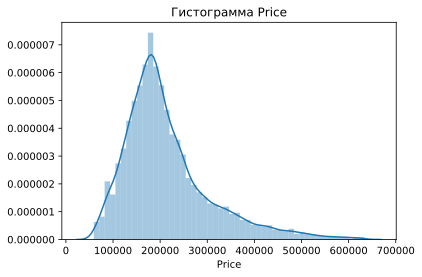

In [57]:
plt.title(f'Гистограмма {dependent}')
sns.distplot(df[dependent])
plt.show()

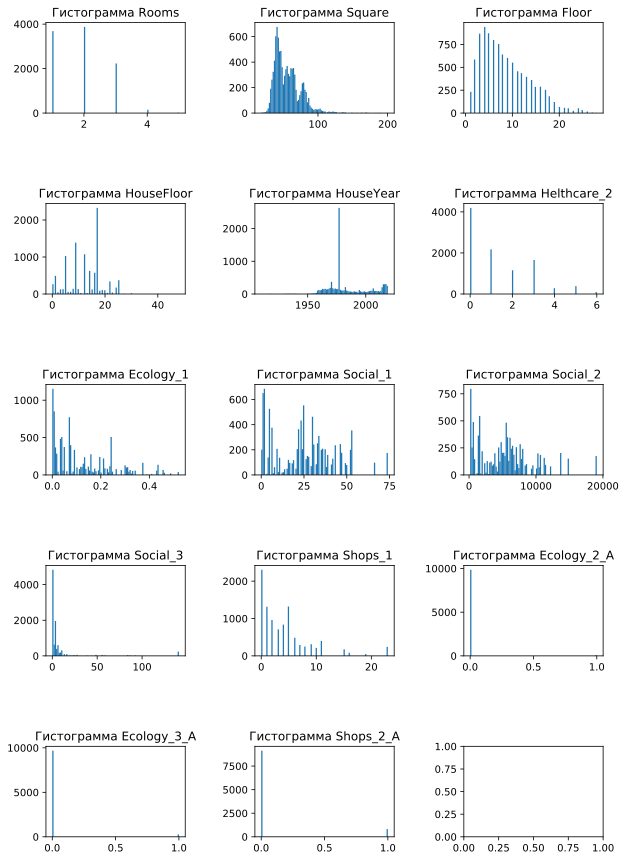

In [49]:
fig, ax = plt.subplots(nrows=5, ncols=3)
axf = ax.flatten()
for i,variable in enumerate(independent):
    axf[i].hist(df[variable],bins=100)
    axf[i].set_title(f'Гистограмма {variable}')
fig.set_size_inches(10,15)
plt.subplots_adjust(wspace=0.5,hspace=1)

Мы видим разного рода особенности включенных переменных, но в данный момент обратим внимание на переменные Price и Square. График гистограммы этих распределений наиболее близок к распределнию хи-квадрат, что указывает на асимптотическую сходимость и может указывать на ненормальность ошибок. Сформулируем гипотезу $H_0: \epsilon_i \vert X \sim N({0,\sigma^2})$. Перед тем как использовать тесты для проверки этой гипотезы построим гистограмму оценок ошибок и т.н. график квантилей (Quantile-Quantile plots).

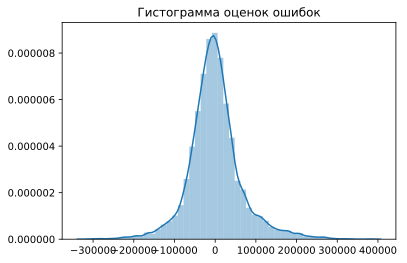

In [34]:
plt.title(f'Гистограмма оценок ошибок')
sns.distplot(model_1.residuals)
plt.show()

Построенная гистограмма на первый взгляд очень похожа на нормальное распределение с нулевым средним.

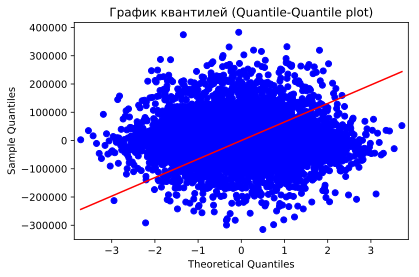

In [55]:
from statsmodels.graphics.gofplots import qqplot
qqplot(model_1.residuals, line='s')
plt.title('График квантилей (Quantile-Quantile plot)')
plt.show()

График квантилей (Quantile-Quantile plot) показывает на сколько распределение случайной величины похоже на нормальное. При нормальном распределении проверяемой переменной точки на графике квантилей должны выстраиваться в прямую линию, исходящую под улом 45 градусов из левого нижнего угла графика.Но график квантилей сигнализирует о явно не похожем на нормальное распределнии т.к. распределение квантилей даже близко не похоже на линию.

Протестируем гипотезу о нормальности ошибок двумя тестами. Обобщённым тестом Д'Агостино-Пирсона и тестом Андерсона-Дарлинга, которые подходят для больших объёмов выборк. Тест Андерсона возвращает наблюдаемое значение статистики, а также критические уровни для уровней значимости от 1% до 15%. Тест Д'Агостино-Пирсона возвращает наблюдаемое значение статистики и p-значение.

In [41]:
# тест Андерсона-Дарлинга
stats.anderson((model_1.residuals).flatten())


AndersonResult(statistic=136.0000618243921, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [50]:
# Тест Д'Агостино-Пирсона
stats.normaltest(model_1.residuals)

NormaltestResult(statistic=array([1096.99734976]), pvalue=array([6.16669074e-239]))

Легко заметить, что наблюдаемое значение статистики по обоим тестам очень большое, что говорит о том, что гипотеза $H_0$ отвергается. Таким образом мы не можем использовать стастистику Стьюдента для проверки гипотез о незначимости коэффициентов регрессии, вместо неё будем использовать  статистику:
$$\frac{\widehat\beta - \beta}{se(\widehat\beta)} \to N_{0,1}$$
А для проверки гипотез о совместной незначимости отдельных независимсых переменный и регрессии в целом, будет использовать хи-квадрат статистику, вместо статистики Фишера.
Уберём из модели переменную Social_1, чтобы избавиться от явной мультиколлениарности и проверим гипотезы о незначимости каждого фактора отдельно и регрессии в целом.

In [7]:
independent.remove('Social_1')
model_2 = Model(df,dependent,independent)
model_2.summary(norm=True)

,Intercept,Rooms,Square,Floor,HouseFloor,HouseYear,Helthcare_2,Ecology_1,Social_2,Social_3,Shops_1,Ecology_2_A,Ecology_3_A,Shops_2_A
Оценки МНК,641741,25463.4,2098.72,1535.94,845.994,-325.723,11082.9,-33988.4,4.22419,83.5854,-948.671,-17683.4,27051.1,-15782.2
Стандартное отклонение оценок,83946.5,1383.77,60.76,144.769,120.55,42.7523,550.925,5887.45,0.244624,43.3115,258.366,6952.35,4275.03,2493.8
p-значения,0,0,0,0,0,0,0,0,0,0.05362,0.00024,0.01097,0,0
наблюдаемое значение,7.64465,18.4014,34.5411,10.6096,7.01779,-7.61884,20.1168,-5.77302,17.2681,1.92986,-3.67181,-2.54352,6.32768,-6.32858


Квантиль  5% уровня значимости: 1.96 Квантиль 1% уровня значимости: 2.58
Значения F-статистики наблюдаемое: 711.61, критическое: 1.72, p-значение: 0.0000
Показатели качества модели R^2: 0.4820 R^2 adjusted: 0.4814, AIC: 221171.29, BIC: 221272.17


Практически все факторы кроме Social_3 оказались значимыми. Регрессия в целом также оказалась значима на высоком уровне. Уберём незначимую переменную Social_3 и построим регрессию ещё раз.

In [8]:
independent.remove('Social_3')
model_3 = Model(df,dependent,independent)
model_3.summary(norm=True)

,Intercept,Rooms,Square,Floor,HouseFloor,HouseYear,Helthcare_2,Ecology_1,Social_2,Shops_1,Ecology_2_A,Ecology_3_A,Shops_2_A
Оценки МНК,648228,25416.3,2100.16,1529.93,842.854,-328.773,11194,-34976.1,3.99863,-587.938,-16886.4,26846.5,-15947.6
Стандартное отклонение оценок,83890.7,1383.75,60.7637,144.755,120.555,42.729,547.983,5865.97,0.214925,178.387,6941.02,4274.31,2492.67
p-значения,0,0,0,0,0,0,0,0,0,0.00098,0.01498,0,0
наблюдаемое значение,7.72706,18.3677,34.5627,10.5691,6.99143,-7.69438,20.4276,-5.96255,18.6048,-3.29586,-2.43284,6.2809,-6.3978


Квантиль  5% уровня значимости: 1.96 Квантиль 1% уровня значимости: 2.58
Значения F-статистики наблюдаемое: 770.39, критическое: 1.75, p-значение: 0.0000
Показатели качества модели R^2: 0.4819 R^2 adjusted: 0.4812, AIC: 221173.02, BIC: 221266.69


Заметим тот факт, что несмотря на практически линейную связь Social_1 и Social_2 и незначимость Social_3, показатель R2 был самым высоким в самой первой модели, уменьшаясь каждый раз, когда мы убирали переменную. Этот факт напоминает нам о том, что показатель R2 не стоит использоват для сравнения качества одной и той же модели с разным количеством переменных, т.к. при прочих равных условиях R_2 будет тем больше, чем больше переменных включенно в регрессию, даже если они не значимы. Вместо этого стоит использовать информационные критерии AIC и BIC, которые "штрафуют" за количество регрессоров.

In [16]:
pd.DataFrame(data = [[model_1.R2[0],model_2.R2[0],model_3.R2[0]],[model_1.AIC[0],model_2.AIC[0],model_3.AIC[0]]],index=['R^2','AIC'],columns=['Модель №1','Модель №2','Модель №3']).astype(object)

,Модель №1,Модель №2,Модель №3
R^2,0.499598,0.482047,0.481853
AIC,220830,221171,221173


Проведём тест Рамсея, чтобы узнать не пропущены ли значимые переменные. Нулевая гипотеза будет состоять в том, что модель 3 спецефицирована правильно и она является истиной. Альтернативная гипотеза состоит в том,
что мы пропустили и не включили некоторый набор регрессоров, которые стоило бы включить.

На первом шаге теста Рамсея оценивается исходная модель, и из неё получаем прогнозы $\widehat y$ (y_estimated) . На втором шаге оценивается
вспомогательная регрессия, то есть строится регрессия y на исходные переменные и на степени прогнозов из регрессии на первом шаге.
В нашем случае ограничемся $\widehat y^2$ и $\widehat y^3$. Далее считается обычная F-статистика, проверяющая гипотезу
о равенстве нулю всех коэффициентов перед искусственными переменными.
Гипотеза о равенстве нулю всех коэффициентов перед этими новыми
переменными. Идея теста заключается в том, что если мы пропустили какую-то переменную, то, наверное, эта переменная останется в $\widehat y$ и, соответственно, мы с помощью степеней $\widehat y$ будем заменять эту самую пропущенную переменную.

Для проверки теста нам требуется расчитаь следующую статистику:

$$ F = \frac{(RSS_R - RSS_{UR})/r}{RSS_{UR}/(n-k_{UR})} \sim  F_{r,n-k_{UR}}$$

где $RSS_R$ - это RSS модели с исходными переменными, в нашем случае Модель 3, $RSS_{UR}$ - это RSS модели с искусственными переменными.


In [26]:
ramsey_df = df.copy()
ramsey_df['y_estimated^2'] = model_3.y_estimated ** 2
ramsey_df['y_estimated^3'] = model_3.y_estimated ** 3
ramsey_model = Model(ramsey_df,dependent,independent + ['y_estimated^2','y_estimated^3'])

F_observed = ( (model_3.RSS - ramsey_model.RSS)/2 ) / (ramsey_model.RSS / (ramsey_model.n - ramsey_model.k))
F_crit = scipy.stats.f.ppf(0.95, 2, ramsey_model.n - ramsey_model.k)
F_pvalue = 1 - scipy.stats.f.cdf(F_observed, 2, ramsey_model.n - ramsey_model.k)
print(f'Значения F-статистики наблюдаемое: {F_observed[0]:.2f}, критическое: {F_crit:.2f}, p-значение: {F_pvalue[0]:.4f}')

Значения F-статистики наблюдаемое: 51.37, критическое: 3.00, p-значение: 0.0000


In [ ]:
Таким образом гипотеза об отсутствии пропущенных переменных отвергается.